# MALLORN TDE Classification v1.2 - Dự đoán & Submission

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path('../mallorn-astronomical-classification-challenge')
sns.set_style('whitegrid')

## Tải Model

In [2]:
model = joblib.load('lgb_model.joblib')
scaler = joblib.load('scaler.joblib')
model_info = joblib.load('model_info.joblib')

best_threshold = model_info['best_threshold']
feature_cols = model_info['feature_cols']

print(f"v1.2 Model loaded")
print(f"CV F1: {model_info['best_f1']:.4f}")
print(f"Threshold: {best_threshold:.3f}")
print(f"Features: {len(feature_cols)}")

v1.2 Model loaded
CV F1: 0.5972
Threshold: 0.470
Features: 306


## Tải Dữ liệu Test

In [3]:
test_features = pd.read_csv('test_features.csv')
test_log = pd.read_csv(DATA_DIR / 'test_log.csv')

print(f"Test features: {len(test_features)}")
print(f"Expected: {len(test_log)}")

Test features: 7135
Expected: 7135


## Chuẩn bị & Dự đoán

In [4]:
# Ensure all features exist
for f in feature_cols:
    if f not in test_features.columns:
        test_features[f] = 0

X_test = test_features[feature_cols].values
X_test_scaled = scaler.transform(X_test)

# Predict
test_proba = model.predict_proba(X_test_scaled)[:, 1]
test_preds = (test_proba >= best_threshold).astype(int)

print(f"\nPredictions:")
print(f"  TDEs: {np.sum(test_preds)} ({100*np.mean(test_preds):.2f}%)")
print(f"  Non-TDEs: {np.sum(test_preds == 0)}")


Predictions:
  TDEs: 371 (5.20%)
  Non-TDEs: 6764


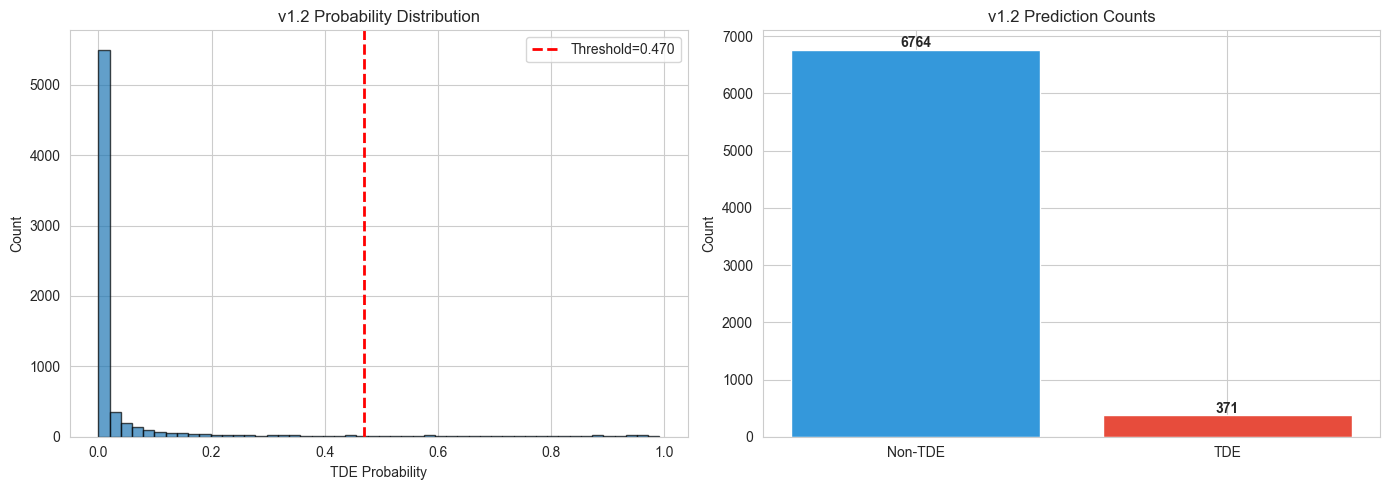

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.hist(test_proba, bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(best_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold={best_threshold:.3f}')
ax1.set_xlabel('TDE Probability')
ax1.set_ylabel('Count')
ax1.set_title('v1.2 Probability Distribution')
ax1.legend()

ax2 = axes[1]
counts = [np.sum(test_preds == 0), np.sum(test_preds == 1)]
bars = ax2.bar(['Non-TDE', 'TDE'], counts, color=['#3498db', '#e74c3c'])
ax2.set_ylabel('Count')
ax2.set_title('v1.2 Prediction Counts')
for bar, count in zip(bars, counts):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, f'{count}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('prediction_distribution.png', dpi=150)
plt.show()

## Tạo Submission

In [6]:
submission = pd.DataFrame({
    'object_id': test_features['object_id'],
    'target': test_preds
})

# Handle missing objects
all_test_ids = set(test_log['object_id'])
submission_ids = set(submission['object_id'])
missing_ids = all_test_ids - submission_ids

if missing_ids:
    print(f"Adding {len(missing_ids)} missing objects with target=0")
    missing_df = pd.DataFrame({'object_id': list(missing_ids), 'target': 0})
    submission = pd.concat([submission, missing_df], ignore_index=True)

# Match order
submission = submission.set_index('object_id').loc[test_log['object_id']].reset_index()

print(f"\nSubmission: {len(submission)} rows")
print(f"Expected: {len(test_log)} rows")
print(f"Match: {'✓' if len(submission) == len(test_log) else '✗'}")


Submission: 7135 rows
Expected: 7135 rows
Match: ✓


In [7]:
submission.to_csv('submission.csv', index=False)

print("\n" + "="*60)
print("v1.2 SUBMISSION CREATED")
print("="*60)
print(f"File: submission.csv")
print(f"Rows: {len(submission)}")
print(f"TDEs: {submission['target'].sum()} ({100*submission['target'].mean():.2f}%)")
print(f"\nCV F1: {model_info['best_f1']:.4f}")
print("="*60)


v1.2 SUBMISSION CREATED
File: submission.csv
Rows: 7135
TDEs: 371 (5.20%)

CV F1: 0.5972


In [8]:
# Save full predictions
full_pred = pd.DataFrame({
    'object_id': test_features['object_id'],
    'probability': test_proba,
    'prediction': test_preds
})
full_pred.to_csv('full_predictions.csv', index=False)
print("Full predictions saved to full_predictions.csv")

Full predictions saved to full_predictions.csv
